<a href="https://colab.research.google.com/github/Basavarajta/Covid-19/blob/main/Basavaraj_L_Hiremath.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Name: Basavaraj L Hiremath
#Student ID : LOK21549000

**Loading the data from kaggle**
The dataset for pneumonia detection typically consists of X-ray images labeled as either "pneumonia" or "healthy"

In [1]:
import os

os.environ['KAGGLE_CONFIG_DIR'] ='/content'

In [2]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
100% 2.29G/2.29G [01:44<00:00, 25.1MB/s]
100% 2.29G/2.29G [01:44<00:00, 23.7MB/s]


In [3]:
!unzip chest-xray-pneumonia.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating:

In [4]:
from fastai import *

from fastai.vision.all import *

from fastai.metrics import error_rate

import pandas as pd

import numpy as np

In [5]:
path ='/content/chest_xray/chest_xray'

In [6]:
data = ImageDataLoaders.from_folder(



path,

train = '.',

valid_pct=0.2,

seed = 42,

item_tfms=Resize(224)
)

To feed x-ray images into the neural network, you need to resize them to a consistent shape 224x224 pixel which is a common size used for CNNs

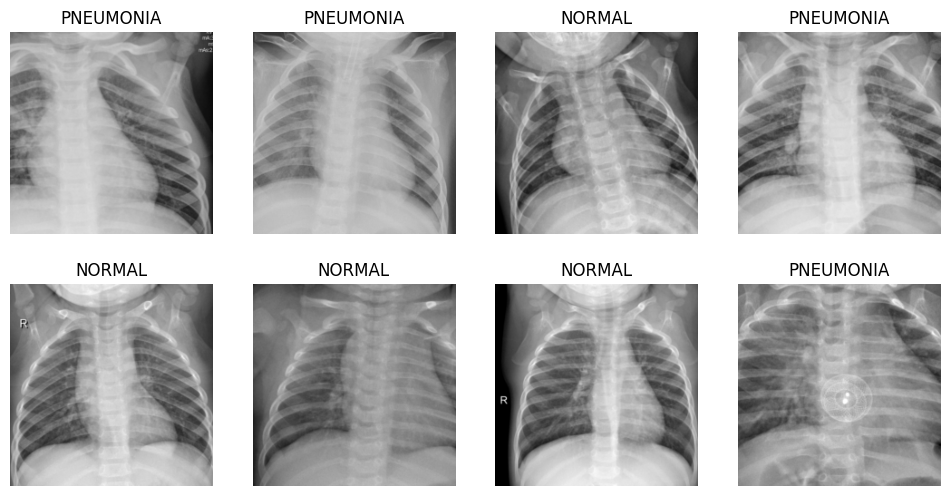

In [7]:
data.show_batch(max_n=8)

From the above figures we can see the sample Pneumonia and normal X-ray images.

**Data Augmentation** : This is a technique to artificially increase the size of the dataset by applying random transformations (e.g., rotation, flipping, scaling). This helps to prevent overfitting and improve the model's ability to generalize to new, unseen data.

In [8]:
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator


IMG_SIZE = 224

def load_and_preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img.astype("float32") / 255.0
    return img


image_path = '/content/chest_xray/test/NORMAL/IM-0001-0001.jpeg'
image = load_and_preprocess_image(image_path)


In [9]:

train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values
    shear_range=0.2,  # Random shear transformation
    zoom_range=0.2,  # Random zoom
    horizontal_flip=True  # Random horizontal flip
)


**Split the Data**
Training Set: Used to train the model.
Validation Set: Used to evaluate the model during training to prevent overfitting.
Test Set: Used to evaluate the model after training.

In [10]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50


train_dir = '/content/chest_xray/train'
val_dir = '/content/chest_xray/val'


train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


**Data visualisation**

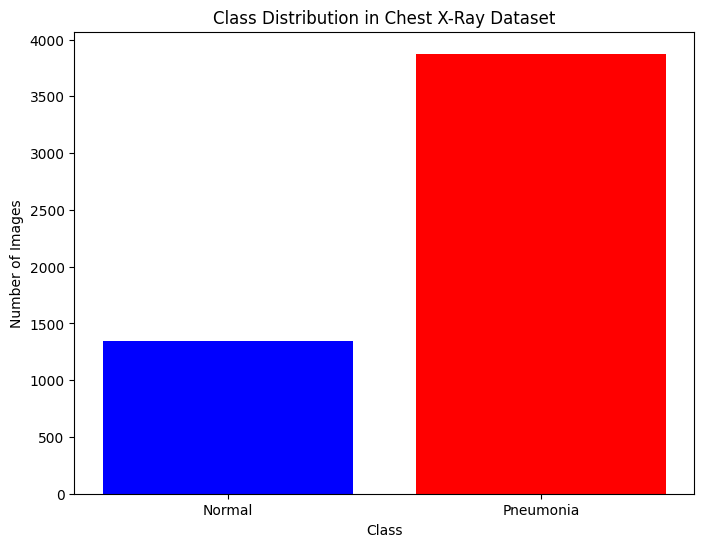

In [11]:
import os
import matplotlib.pyplot as plt


train_normal_dir = '/content/chest_xray/train/NORMAL'
train_pneumonia_dir = '/content/chest_xray/train/PNEUMONIA'


num_normal_images = len(os.listdir(train_normal_dir))
num_pneumonia_images = len(os.listdir(train_pneumonia_dir))


classes = ['Normal', 'Pneumonia']
image_counts = [num_normal_images, num_pneumonia_images]


plt.figure(figsize=(8, 6))
plt.bar(classes, image_counts, color=['blue', 'red'])
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Class Distribution in Chest X-Ray Dataset')
plt.show()

#From the above figure we can say that pneumonia x-ray images are more when compared to the normal x-ray image

**#Preparing the Data**


In [12]:
import os

train_dir = '/content/chest_xray/train'
class_names = os.listdir(train_dir)


for class_name in class_names:
    class_path = os.path.join(train_dir, class_name)
    num_images = len(os.listdir(class_path))
    print(f"Class: {class_name}, Number of images: {num_images}")


Class: PNEUMONIA, Number of images: 3875
Class: NORMAL, Number of images: 1341


#From above code we can say that totally there are 5876 x-ray images, in that 1341 are of normal and 3875 are of pneumonia x-ray image.

 Image Preprocessing

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set up ImageDataGenerator for preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values to [0, 1]
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

**Defining the Deep Learning Model**
Convolutional Layers (Conv2D): These layers apply convolution operations to extract features such as edges, textures, and patterns from the image.
Pooling Layers (MaxPooling2D): These layers reduce the spatial dimensions (height and width) of the image while retaining the important features.
Fully Connected Layers (Dense): After extracting features, the fully connected layers classify the image based on the learned features.
Activation Functions: We use activation functions to introduce non-linearity. ReLU (Rectified Linear Unit) is commonly used in convolutional layers, and sigmoid is used in the output layer for binary classification.

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Initialize the model
model = Sequential()

# Convolutional Layer 1
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(MaxPooling2D(2, 2))

# Convolutional Layer 2
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))

# Convolutional Layer 3
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))

# Flatten the output from convolutional layers
model.add(Flatten())

# Fully Connected Layer
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # Dropout to prevent overfitting

# Output Layer (1 neuron for binary classification)
model.add(Dense(1, activation='sigmoid'))  # Sigmoid for binary classification

# Compile the model with the correct learning_rate argument
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Display model architecture
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 36992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       4,735,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,828,481 (18.42 MB)

 Trainable params: 4,828,481 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

Conv2D Layers: These detect patterns in images. In the first layer, the model uses 32 filters, each of size (3x3), and applies the ReLU activation function.
MaxPooling2D: This reduces the dimensionality of the data, which helps to decrease computational load and avoid overfitting.
Flatten: Converts the 2D data into a 1D vector that can be fed into the fully connected layers.
Dense Layers: These layers perform the final classification, using the features extracted by the convolutional layers.
Dropout: Randomly drops a fraction (50%) of units in the fully connected layer to prevent overfitting.
Sigmoid Activation: Since this is a binary classification problem (pneumonia vs. no pneumonia), the sigmoid function outputs a probability value between 0 and 1.

Training and Fine-Tuning the Model

In [15]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // 32,  # Number of batches per epoch
    epochs=10,  # Adjust epochs based on dataset
    validation_data=val_generator,
    validation_steps=val_generator.samples // 32  # Number of validation steps
)


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


163/163 ━━━━━━━━━━━━━━━━━━━━ 78s 418ms/step - accuracy: 0.7386 - loss: 0.5518 - val_accuracy: 0.6250 - val_loss: 0.9126
Epoch 2/10


/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.6250 - val_loss: 0.9126
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 68s 400ms/step - accuracy: 0.8515 - loss: 0.2984 - val_accuracy: 0.8125 - val_loss: 0.5360
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 823us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8125 - val_loss: 0.5360
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 67s 398ms/step - accuracy: 0.8776 - loss: 0.2640 - val_accuracy: 0.8125 - val_loss: 0.4307
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 824us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8125 - val_loss: 0.4307
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 82s 399ms/step - accuracy: 0.8939 - loss: 0.2607 - val_accuracy: 0.6875 - val_loss: 0.7344
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 924us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.6875 - val_loss: 0.7344
Epoch 9/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 67s 398ms/step - accuracy: 0

In [16]:
# Unfreeze the layers of the base model


# Recompile the model after unfreezing the layers
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  # Use a smaller learning rate for fine-tuning
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Fine-tune the model
history_finetune = model.fit(
    train_generator,
    steps_per_epoch=2000 // 32,
    epochs=5,
    validation_data=val_generator,
    validation_steps=800 // 32
)


Epoch 1/5
62/62 ━━━━━━━━━━━━━━━━━━━━ 32s 428ms/step - accuracy: 0.9201 - loss: 0.2007 - val_accuracy: 0.6875 - val_loss: 0.7742
Epoch 2/5
62/62 ━━━━━━━━━━━━━━━━━━━━ 26s 418ms/step - accuracy: 0.9272 - loss: 0.2232 - val_accuracy: 0.8125 - val_loss: 0.5072
Epoch 3/5
62/62 ━━━━━━━━━━━━━━━━━━━━ 14s 225ms/step - accuracy: 0.9140 - loss: 0.2212 - val_accuracy: 0.8125 - val_loss: 0.4870
Epoch 4/5
62/62 ━━━━━━━━━━━━━━━━━━━━ 41s 425ms/step - accuracy: 0.9384 - loss: 0.1799 - val_accuracy: 0.6875 - val_loss: 0.5819
Epoch 5/5
62/62 ━━━━━━━━━━━━━━━━━━━━ 26s 430ms/step - accuracy: 0.9295 - loss: 0.2031 - val_accuracy: 0.6875 - val_loss: 0.7400


Learning Rate: How quickly the model learns.
Batch Size: The number of samples used in each update.
Epochs: Number of times the model iterates over the dataset.

**Evaluating the Model**

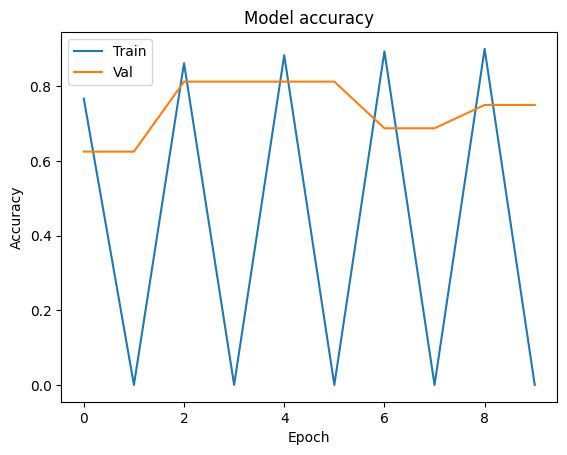

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.6875 - loss: 0.7400
Validation Accuracy: 0.6875, Validation Loss: 0.7399674654006958


In [17]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Evaluate the model on validation data
val_loss, val_acc = model.evaluate(val_generator)
print(f"Validation Accuracy: {val_acc}, Validation Loss: {val_loss}")


**Testing Model with New Data**

In [20]:
def preprocess_image(img_path):
    """
    Preprocess the input image to match the format the model was trained on.
    """
    img = image.load_img(img_path, target_size=(150, 150))  # Resize the image to 150x150 (same as training data)
    img_array = image.img_to_array(img)  # Convert image to a numpy array
    img_array = np.expand_dims(img_array, axis=0)  # Expand dims to match batch format (1, 150, 150, 3)
    img_array = img_array / 255.0  # Normalize pixel values to [0, 1]
    return img_array



In [27]:
model.save('pneumonia_model.h5')


In [28]:
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

# Load the pre-trained pneumonia detection model
model = load_model('pneumonia_model.h5')  # Replace with the path to your trained model

def predict_pneumonia(img_path):
    """
    Function to predict whether the chest X-ray indicates pneumonia or not.

    Parameters:
    - img_path (str): Path to the chest X-ray image file.

    Returns:
    - str: Predicted class ("Pneumonia" or "Normal").
    """
    # Load and preprocess the image
    img = image.load_img(img_path, target_size=(150, 150))  # Resize to model's input size
    img_array = image.img_to_array(img)  # Convert to a NumPy array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize pixel values to [0, 1]

    # Make a prediction
    prediction = model.predict(img_array)  # Model outputs a probability
    predicted_class = "Pneumonia" if prediction[0][0] > 0.5 else "Normal"

    return predicted_class

# Example usage
img_path = '/content/chest_xray/chest_xray/test/NORMAL/IM-0001-0001.jpeg'  # Specify your image path
prediction = predict_pneumonia(img_path)
print(f"Predicted Diagnosis: {prediction}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
Predicted Diagnosis: Normal


In [30]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

# Load the trained model
model = load_model('pneumonia_model.h5')  # Update with the correct path to your model

# Function to load and preprocess images
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(150, 150))  # Resize to the input size expected by the model
    img_array = image.img_to_array(img)  # Convert the image to a numpy array
    img_array = np.expand_dims(img_array, axis=0)  # Add a batch dimension
    img_array = img_array / 255.0  # Normalize to [0,1]
    return img_array

# Function to predict the class of an image
def predict_class(img_path):
    img_array = preprocess_image(img_path)
    prediction = model.predict(img_array)
    return np.argmax(prediction, axis=-1)[0]  # Get the predicted class (0 or 1)

# Evaluate the model on the test data
def evaluate_model(test_images, test_labels):
    predictions = []

    # Loop through the test images and get the predictions
    for img_path in test_images:
        predicted_class = predict_class(img_path)
        predictions.append(predicted_class)

    # Generate classification report
    report = classification_report(test_labels, predictions, target_names=['Normal', 'Pneumonia'])
    print("Classification Report:\n", report)

    # Generate confusion matrix
    cm = confusion_matrix(test_labels, predictions)
    print("Confusion Matrix:\n", cm)

    return report, cm

# Example Usage
test_images = ['/content/chest_xray/chest_xray/test/NORMAL/IM-0001-0001.jpeg', '/content/chest_xray/chest_xray/test/PNEUMONIA/person100_bacteria_475.jpeg']  # List of test image paths
test_labels = [0, 1]  # Actual labels for test images (0 for Normal, 1 for Pneumonia)

# Evaluate the model on the new test data
evaluate_model(test_images, test_labels)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Classification Report:
               precision    recall  f1-score   support

      Normal       0.50      1.00      0.67         1
   Pneumonia       0.00      0.00      0.00         1

    accuracy                           0.50         2
   macro avg       0.25      0.50      0.33         2
weighted avg       0.25      0.50      0.33         2

Confusion Matrix:
 [[1 0]
 [1 0]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


('              precision    recall  f1-score   support\n\n      Normal       0.50      1.00      0.67         1\n   Pneumonia       0.00      0.00      0.00         1\n\n    accuracy                           0.50         2\n   macro avg       0.25      0.50      0.33         2\nweighted avg       0.25      0.50      0.33         2\n',
 array([[1, 0],
        [1, 0]]))